In [1]:
import os
import sys
import pandas as pd
import chardet
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
import numpy as np
from numpy import random
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV
from sklearn.cluster import KMeans
import functions
from scipy import stats
from sklearn.cluster import DBSCAN
import seaborn as sns

%matplotlib inline
rndseed = functions.RNDSEED

# Sample Model

    - feature selection based on lasso
    - performance tested with r2
    
    - theoritcally tho, should have all the data imported first, then do a train test split

In [2]:
result = ''
# filename = '/projects/ads_co2_eu/shared/data/CO2_passenger_cars_v14.csv' # test file from 16
# filename = '/projects/ads_co2_eu/shared/data/merged.csv' # complete merged file, too large
filename = '/projects/ads_co2_eu/shared/pv_co2.csv'
with open(filename, 'rb') as f:
        result = chardet.detect(f.read())
df = pd.read_csv(filename, sep='\t', encoding=result['encoding'])

In [3]:
df.head()

,Unnamed: 0,Ft,MP,MS,at1 (mm),at2 (mm),e (g/km),ec (cm3),ep (KW),m (kg),w (mm),year
0,0,Petrol,NaN,AT,1468.0,1471.0,155.0,1598.0,NaN,1240.0,2452.0,2011
1,1,Petrol,NaN,AT,1537.0,1575.0,314.0,5666.0,NaN,1225.0,2575.0,2011
2,2,Electric,NaN,AT,1220.0,1220.0,0.0,NaN,NaN,1415.0,1810.0,2011
3,3,Diesel,NaN,AT,1565.0,1565.0,NaN,2199.0,NaN,1788.0,2620.0,2011
4,4,Diesel,NaN,AT,1565.0,1565.0,NaN,2199.0,NaN,1727.0,2620.0,2011


In [4]:
df.shape

(2509155, 12)

In [5]:
'''er is the emission reduced through innovative technology
   z is the electric energy consumbed 
   would've been very useful, but most of them are nans
'''
# temp = df[['Er (g/km)', 'z (Wh/km)']]
# print(temp.iloc[:, 0].isnull().sum().sum() / temp.shape[0] * 100, '% of column 1 is nan')
# print(temp.iloc[:, 1].isnull().sum().sum() / temp.shape[0] * 100, '% of column 2 is nan')

"er is the emission reduced through innovative technology\n   z is the electric energy consumbed \n   would've been very useful, but most of them are nans\n"

# Pre processing data
        - create categorical vars by fuel type and manufacture group
        - remove duplicates

In [6]:
# extract only necessary data
all_data = pd.DataFrame(df[functions.feature_dict])

# include these columns to pass to the clustering notebook
all_data['MP'] = df.MP
all_data['MS'] = df.MS
# all_data['Ft'] = df.Ft

# include fuel type and manufecture group into the dataframe as categorical variables
for elem in np.unique(df['Ft'].astype(str).str.upper()):
    if elem == 'NAN' or elem == 'NA' or elem == ' ':  continue
    colname = functions.ft_dict[elem]
    try:
        all_data[colname] += (df['Ft'].astype(str).str.upper() == elem).astype(int)
    except:
        all_data[colname] = (df['Ft'].astype(str).str.upper() == elem).astype(int)
for elem in np.unique(pd.Series(df.MP).astype(str).str.upper()):
    if elem == 'NAN' or elem == 'NA' or elem == ' ':  continue
    colname = functions.mp_dict[elem]
    try:
        all_data[colname] += (df['MP'].astype(str).str.upper() == elem).astype(int)
    except:
        all_data[colname] = (df['MP'].astype(str).str.upper() == elem).astype(int)
    
# remove duplicates, drop na, and rename categorical variables
all_data.drop_duplicates(keep=False, inplace=True)
all_data.dropna(inplace=True)
all_data.index = range(all_data.shape[0])

# include the market share of each group into the data
ls = all_data.columns[-16:]
total = 0
for i in ls:
    total += sum(all_data[i])
share = []
for i in ls:
    share.append(sum(all_data[i]) / total)
grps = pd.DataFrame([ls, share], index=['MP', 'share']).T
all_data['share'] = [0.]*len(all_data)
for i in range(len(ls)):
    for j in all_data[ls[i]][all_data[ls[i]] > 0].index:
        all_data.set_value(j, 'share', share[i])

# extract the numerical data for standarization
data = pd.DataFrame(all_data[functions.feature_dict])

all_data.head()
print(all_data.columns)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:42: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Index(['e (g/km)', 'm (kg)', 'w (mm)', 'at1 (mm)', 'at2 (mm)', 'ec (cm3)',
       'ep (KW)', 'MP', 'MS', 'BIODIESEL', 'CNG', 'DIESEL', 'DIESEL_ELECTRIC',
       'E85', 'ELECTRIC', 'PETROL_ELECTRIC', 'HYDROGEN', 'LPG', 'BIOMETHANE',
       'OTHER', 'PETROL', 'UNKNOWN', 'BMW', 'DAIMLER', 'FCA', 'FIAT', 'FORD',
       'GM', 'HONDA', 'HYUNDAI', 'KIA', 'MITSUBISHI', 'RENAULT', 'SUZUKI',
       'TATA_JAGUAR_LANDROVER', 'TJL', 'TOYOTA_DAIHATSU', 'VW', 'share'],
      dtype='object')


In [7]:
all_data.head()

,e (g/km),m (kg),w (mm),at1 (mm),at2 (mm),ec (cm3),ep (KW),MP,MS,BIODIESEL,...,HYUNDAI,KIA,MITSUBISHI,RENAULT,SUZUKI,TATA_JAGUAR_LANDROVER,TJL,TOYOTA_DAIHATSU,VW,share
0,99.0,1350.0,2578.0,1540.0,1533.0,1598.0,77.0,VW Group PC,BE,0,...,0,0,0,0,0,0,0,0,1,0.339857
1,112.0,1415.0,2578.0,1522.0,1515.0,1595.0,77.0,VW Group PC,BE,0,...,0,0,0,0,0,0,0,0,1,0.339857
2,143.0,1460.0,2578.0,1522.0,1515.0,1968.0,100.0,VW Group PC,BE,0,...,0,0,0,0,0,0,0,0,1,0.339857
3,149.0,1370.0,2578.0,1522.0,1515.0,1798.0,118.0,VW Group PC,BE,0,...,0,0,0,0,0,0,0,0,1,0.339857
4,164.0,1370.0,2578.0,1522.0,1515.0,1984.0,147.0,VW Group PC,BE,0,...,0,0,0,0,0,0,0,0,1,0.339857


In [8]:
'''share the cleaned df'''
%store all_data

Stored 'all_data' (DataFrame)


In [9]:
'''all of the fuel types'''
all_data.columns[7:19].values

array(['MP', 'MS', 'BIODIESEL', 'CNG', 'DIESEL', 'DIESEL_ELECTRIC', 'E85',
       'ELECTRIC', 'PETROL_ELECTRIC', 'HYDROGEN', 'LPG', 'BIOMETHANE'], dtype=object)

In [10]:
'''market share by manufacture group'''
grps.sort_values(by='share', ascending=False)

,MP,share
15,VW,0.339857
1,DAIMLER,0.154855
0,BMW,0.105438
10,RENAULT,0.102416
5,GM,0.0768138
4,FORD,0.0513925
14,TOYOTA_DAIHATSU,0.0401627
12,TATA_JAGUAR_LANDROVER,0.0269685
8,KIA,0.0261949
7,HYUNDAI,0.0232091


In [11]:
'''export to csv'''
all_data.to_csv('all_data.csv')

In [12]:
pd.read_csv('all_data.csv').columns

Index(['Unnamed: 0', 'e (g/km)', 'm (kg)', 'w (mm)', 'at1 (mm)', 'at2 (mm)',
       'ec (cm3)', 'ep (KW)', 'MP', 'MS', 'BIODIESEL', 'CNG', 'DIESEL',
       'DIESEL_ELECTRIC', 'E85', 'ELECTRIC', 'PETROL_ELECTRIC', 'HYDROGEN',
       'LPG', 'BIOMETHANE', 'OTHER', 'PETROL', 'UNKNOWN', 'BMW', 'DAIMLER',
       'FCA', 'FIAT', 'FORD', 'GM', 'HONDA', 'HYUNDAI', 'KIA', 'MITSUBISHI',
       'RENAULT', 'SUZUKI', 'TATA_JAGUAR_LANDROVER', 'TJL', 'TOYOTA_DAIHATSU',
       'VW', 'share'],
      dtype='object')

# Normalize

In [13]:
scaler = preprocessing.StandardScaler().fit_transform(data)
y = scaler[:, 0]
X = scaler[:, 1:]

# Remove Outlier

In [14]:
# # remove possible typo data
# temp = pd.DataFrame(X)
# temp['y'] = y
# temp = pd.concat([temp, all_data.drop(functions.feature_dict, axis=1)], axis=1)
# for i in range(6):
#     temp = temp[np.abs(temp[i]-temp[i].mean()) <= (3*temp[i].std())]
# temp.dropna(inplace=True)
# X = np.array(temp.iloc[:, 0:6])
# y = np.array(temp.y)

# Lasso

In [15]:
reg = LassoCV(cv=150, random_state=rndseed).fit(X, y)
print(reg.coef_, '\nR2:', reg.score(X, y))

[ 0.25627365  0.09476822  0.          0.02747592  0.34678806  0.1766067 ] 
R2: 0.571843658423


In [16]:
'''drop unused columns'''
all_data.drop('MP', axis=1, inplace=True)
all_data.drop('MS', axis=1, inplace=True)

In [17]:
# model with LASSO
reg_df = pd.DataFrame()
reg_df['y'] = y
reg_df['mass'] = X[:, 0] # mass/wheel base
# reg_df['wheelbase'] = X[:, 1]
# reg_df['enginecap'] = X[:, 4]
reg_df['eng_pwr'] = X[:, 5]
cat = all_data.drop(functions.feature_dict, axis=1)
reg_df = pd.concat([reg_df, cat], axis=1)
reg_df.dropna(inplace=True)
print(reg_df.shape)
reg_lm = smf.ols(formula='y~%s'%'+'.join(reg_df.drop('y',axis=1).columns), data=reg_df).fit()
reg_lm.summary()

(179294, 33)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                 1.393e+04
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:51:14   Log-Likelihood:            -1.5081e+05
No. Observations:              179294   AIC:                         3.017e+05
Df Residuals:                  179265   BIC:                         3.020e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3536      0.043     -8.208      0.000      -0.438      -0.269
mass                      0.6582      0.002    348.335      0.000       0.654       0.662
eng_pwr                   0.3244      0.002    182.739      0.000       0.321       0.328
BIODIESEL                 0.0874      0.101      0.868      0.386      -0.110       0.285
CNG                      -0.0681      0.563     -0.121      0.904      -1.171       1.035
DIESEL                    0.1884      0.043      4.389      0.000       0.104       0.273
DIESEL_ELECTRIC          -2.4805      0.062    -39.887      0.000      -2.602      -2.359
E85                       1.2972      0.051     25.310      0.000       1.197       1.398
ELECTRIC                 -0.9309      0.080    -11.631      0.000      -1.088      -0.774
PETROL_ELECTRIC          -1.7719      0.048    -37.087      0.000      -1.866      -1.678
HYDROGEN              -1.617e-15   4.52e-16     -3.575      0.000    -2.5e-15   -7.31e-16
LPG                       0.8236      0.045     18.157      0.000       0.735       0.913
BIOMETHANE                0.2235      0.048      4.682      0.000       0.130       0.317
OTHER                 -9.011e-16   1.72e-15     -0.525      0.599   -4.26e-15    2.46e-15
PETROL                    0.8542      0.043     19.905      0.000       0.770       0.938
UNKNOWN               -4.107e-16   2.63e-15     -0.156      0.876   -5.57e-15    4.75e-15
BMW                      -0.3090      0.006    -50.286      0.000      -0.321      -0.297
DAIMLER                  -0.1359      0.006    -24.285      0.000      -0.147      -0.125
FCA                       0.1063      0.013      8.352      0.000       0.081       0.131
FIAT                      0.3325      0.012     27.901      0.000       0.309       0.356
FORD                      0.0628      0.008      8.201      0.000       0.048       0.078
GM                       -0.0040      0.007     -0.591      0.554      -0.017       0.009
HONDA                     0.1025      0.015      7.039      0.000       0.074       0.131
HYUNDAI                   0.1206      0.010     11.824      0.000       0.101       0.141
KIA                       0.1245      0.010     12.802      0.000       0.105       0.144
MITSUBISHI                0.2712      0.019     14.450      0.000       0.234       0.308
RENAULT                   0.1737      0.006     28.162      0.000       0.162       0.186
SUZUKI                    0.3531      0.018     19.192      0.000       0.317       0.389
TATA_JAGUAR_LANDROVER    -0.3827      0.010    -38.476      0.000      -0.402      -0.363
TJL                       0.6902      0.039     17.521      0.000       0.613       0.767
TOYOTA_DAIHATSU          -0.1049      0.008    -12.601      0.000      -0.121      -0.089
VW                     

In [18]:
# alternative model with LASSO using the ratio of mass and wheel base
# the ratio of mass and wheel base is not effective (low coef)
reg_df = pd.DataFrame()
reg_df['y'] = y
reg_df['mass'] = X[:, 0]
reg_df['mw_ratio'] = X[:, 0] / X[:, 1] # mass/wheel base
# reg_df['wheelbase'] = X[:, 1]
'''whats engine capacity: https://carbiketech.com/engine-capacity-cc/'''
# reg_df['enginecap'] = X[:, 4] 
reg_df['eng_pwr'] = X[:, 5]
# reg_df['cp_ratio'] = X[:, 5] / X[:, 4]
cat = all_data.drop(functions.feature_dict, axis=1)
reg_df = pd.concat([reg_df, cat], axis=1)
reg_df.dropna(inplace=True)
print(reg_df.shape)
reg_lm = smf.ols(formula='y~%s'%'+'.join(reg_df.drop('y',axis=1).columns), data=reg_df).fit()
reg_lm.summary()

(179294, 34)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                 1.345e+04
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:51:15   Log-Likelihood:            -1.5081e+05
No. Observations:              179294   AIC:                         3.017e+05
Df Residuals:                  179264   BIC:                         3.020e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.3530      0.043     -8.196      0.000      -0.437      -0.269
mass                      0.6582      0.002    348.365      0.000       0.655       0.662
mw_ratio                 -0.0004   9.49e-05     -3.837      0.000      -0.001      -0.000
eng_pwr                   0.3243      0.002    182.680      0.000       0.321       0.328
BIODIESEL                 0.0875      0.101      0.869      0.385      -0.110       0.285
CNG                      -0.0685      0.563     -0.122      0.903      -1.172       1.035
DIESEL                    0.1883      0.043      4.387      0.000       0.104       0.272
DIESEL_ELECTRIC          -2.4795      0.062    -39.872      0.000      -2.601      -2.358
E85                       1.2967      0.051     25.302      0.000       1.196       1.397
ELECTRIC                 -0.9325      0.080    -11.652      0.000      -1.089      -0.776
PETROL_ELECTRIC          -1.7719      0.048    -37.087      0.000      -1.865      -1.678
HYDROGEN               6.772e-15    3.8e-14      0.178      0.858   -6.77e-14    8.12e-14
LPG                       0.8237      0.045     18.160      0.000       0.735       0.913
BIOMETHANE                0.2223      0.048      4.655      0.000       0.129       0.316
OTHER                  1.221e-15    7.3e-15      0.167      0.867   -1.31e-14    1.55e-14
PETROL                    0.8542      0.043     19.904      0.000       0.770       0.938
UNKNOWN                3.147e-15      1e-14      0.314      0.753   -1.65e-14    2.28e-14
BMW                      -0.3091      0.006    -50.300      0.000      -0.321      -0.297
DAIMLER                  -0.1363      0.006    -24.354      0.000      -0.147      -0.125
FCA                       0.1059      0.013      8.318      0.000       0.081       0.131
FIAT                      0.3316      0.012     27.823      0.000       0.308       0.355
FORD                      0.0626      0.008      8.176      0.000       0.048       0.078
GM                       -0.0048      0.007     -0.719      0.472      -0.018       0.008
HONDA                     0.1024      0.015      7.026      0.000       0.074       0.131
HYUNDAI                   0.1201      0.010     11.768      0.000       0.100       0.140
KIA                       0.1246      0.010     12.811      0.000       0.105       0.144
MITSUBISHI                0.2719      0.019     14.488      0.000       0.235       0.309
RENAULT                   0.1737      0.006     28.158      0.000       0.162       0.186
SUZUKI                    0.3530      0.018     19.189      0.000       0.317       0.389
TATA_JAGUAR_LANDROVER    -0.3833      0.010    -38.536      0.000      -0.403      -0.364
TJL                       0.6879      0.039     17.462      0.000       0.611       0.765
TOYOTA_DAIHATSU        

In [19]:
functions.is_os_r2(reg_df, 15) # cross validate the model

IS R-squared for 15 times is 0.6851289576+-0.001
OS R-squared for 15 times is 0.6846773135+-0.003


# different approach

In [20]:
# PCA
pca = PCA(6) # n_components = min(n_samples, n_features)
P = pca.fit_transform(X)
eigenvalues = pca.explained_variance_ratio_
print(eigenvalues, '\n\n', pca.components_, '\n\n', pca.explained_variance_)

[ 0.50715148  0.28000543  0.16266452  0.0285005   0.0164091   0.00526898] 

 [[ 0.48589646  0.39544451  0.34924223  0.35561294  0.45061669  0.39502174]
 [-0.15947364 -0.02591343  0.5870508   0.57937971 -0.37292977 -0.3930783 ]
 [-0.38075106 -0.68623298  0.18689474  0.19036407  0.30875711  0.46649099]
 [ 0.73259648 -0.60775188 -0.00981974 -0.00711089  0.02423958 -0.30529576]
 [ 0.23825093 -0.05168868 -0.00924978  0.00751956 -0.74962205  0.61521497]
 [-0.00634883  0.00153869 -0.7058963   0.70817582  0.00403254 -0.01176748]] 

 [ 3.04292583  1.68004194  0.97599256  0.17100395  0.09845514  0.03161404]


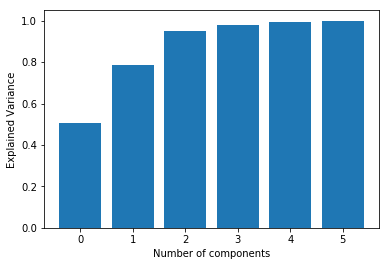

In [21]:
n=P.shape[1]
plt.bar(np.arange(n), eigenvalues.cumsum()/eigenvalues.sum(),align='center');
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [22]:
# 3 PCs are good enough
# model with PCA
pca_df = pd.DataFrame()
pca_df['y'] = y
pca_df['p1'] = P[:, 0]
pca_df['p2'] = P[:, 1]
pca_df['p3'] = P[:, 2]
pca_df = pd.concat([pca_df, cat], axis=1)
pca_df.dropna(inplace=True)
pca_lm = smf.ols(formula='y~%s'%'+'.join(pca_df.drop('y',axis=1).columns), data=pca_df).fit()
pca_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                 1.414e+04
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:51:18   Log-Likelihood:            -1.4773e+05
No. Observations:              179294   AIC:                         2.955e+05
Df Residuals:                  179264   BIC:                         2.958e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4027      0.042     -9.511      0.000      -0.486      -0.320
p1                        0.4603      0.001    548.153      0.000       0.459       0.462
p2                       -0.2405      0.001   -228.926      0.000      -0.243      -0.238
p3                       -0.0698      0.001    -46.926      0.000      -0.073      -0.067
BIODIESEL                 0.1543      0.099      1.559      0.119      -0.040       0.348
CNG                       0.2203      0.553      0.398      0.691      -0.864       1.305
DIESEL                    0.2404      0.042      5.698      0.000       0.158       0.323
DIESEL_ELECTRIC          -2.0986      0.061    -34.351      0.000      -2.218      -1.979
E85                       1.2223      0.050     24.263      0.000       1.124       1.321
ELECTRIC                 -0.7669      0.079     -9.748      0.000      -0.921      -0.613
PETROL_ELECTRIC          -1.5577      0.047    -33.174      0.000      -1.650      -1.466
HYDROGEN               2.952e-15   1.16e-14      0.255      0.798   -1.97e-14    2.56e-14
LPG                       0.7969      0.045     17.872      0.000       0.709       0.884
BIOMETHANE                0.3241      0.047      6.905      0.000       0.232       0.416
OTHER                 -1.058e-15   1.12e-15     -0.946      0.344   -3.25e-15    1.13e-15
PETROL                    0.8420      0.042     19.963      0.000       0.759       0.925
UNKNOWN               -7.562e-15   1.23e-14     -0.614      0.539   -3.17e-14    1.66e-14
BMW                      -0.3590      0.006    -59.346      0.000      -0.371      -0.347
DAIMLER                  -0.1676      0.006    -30.094      0.000      -0.179      -0.157
FCA                       0.1632      0.013     13.020      0.000       0.139       0.188
FIAT                      0.3501      0.012     29.871      0.000       0.327       0.373
FORD                      0.0576      0.008      7.625      0.000       0.043       0.072
GM                        0.1132      0.007     17.158      0.000       0.100       0.126
HONDA                     0.1567      0.014     10.947      0.000       0.129       0.185
HYUNDAI                   0.1494      0.010     14.895      0.000       0.130       0.169
KIA                       0.1594      0.010     16.674      0.000       0.141       0.178
MITSUBISHI                0.3197      0.018     17.326      0.000       0.284       0.356
RENAULT                   0.1575      0.006     25.788      0.000       0.146       0.169
SUZUKI                    0.3573      0.018     19.749      0.000       0.322       0.393
TATA_JAGUAR_LANDROVER    -0.1749      0.010    -18.019      0.000      -0.194      -0.156
TJL                       0.7664      0.039     19.786      0.000       0.691       0.842
TOYOTA_DAIHATSU        

In [23]:
res=LinearRegression()
res.fit(reg_df.drop('y', axis=1), reg_df.y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [24]:
res.coef_

array([  6.58220624e-01,  -3.64267901e-04,   3.24317264e-01,
         8.75410373e-02,  -6.84624240e-02,   1.88300178e-01,
        -2.47950347e+00,   1.29670075e+00,  -9.32502173e-01,
        -1.77185763e+00,   2.22044605e-16,   8.23740198e-01,
         2.22258219e-01,  -2.22044605e-15,   8.54169771e-01,
         5.55111512e-16,  -3.09111314e-01,  -1.36321631e-01,
         1.05897127e-01,   3.31615382e-01,   6.26281475e-02,
        -4.83059473e-03,   1.02356500e-01,   1.20066976e-01,
         1.24551146e-01,   2.71891237e-01,   1.73680525e-01,
         3.53027652e-01,  -3.83317800e-01,   6.87929099e-01,
        -1.04754158e-01,  -1.98240202e-01,  -9.66124556e-02])

In [25]:
%store res

Stored 'res' (LinearRegression)


In [26]:
y_predict = pca_lm.predict(pca_df.drop('y',axis=1))
%store y_predict

Stored 'y_predict' (Series)


In [27]:
functions.is_os_r2(pca_df, 15)

IS R-squared for 15 times is 0.6957806712+-0.001
OS R-squared for 15 times is 0.6950727713+-0.002


In [28]:
reg_lm.compare_lr_test(pca_lm)

(-6146.4896165989921, nan, 0.0)

# Test the sample model on all of the data available

In [29]:
# r2 = []
# for i in range(9, 15):
#     filename = '/projects/ads_co2_eu/shared/data/CO2_passenger_cars_v' + str(i) + '.csv'
#     df = functions.pre_pro(filename)
#     df.drop_duplicates(subset=functions.feature_dict, keep=False, inplace=True)
#     data = df[['e (g/km)', 'm (kg)', 'ep (KW)']]
#     scaler = preprocessing.StandardScaler().fit_transform(data)
#     y = scaler[:, 0]
#     X = scaler[:, 1:]
#     reg_df = pd.DataFrame()
#     reg_df['y'] = y
#     reg_df['mass'] = X[:, 0]
#     reg_df['eng_pwr'] = X[:, 1]
#     y_predict = reg_lm.predict(reg_df[['mass', 'eng_pwr']])
#     os_r2 = metrics.r2_score(y, y_predict)
#     r2.append(os_r2)
#     print(os_r2)

# Add this to a arima thing or whatever

# Model fit

In [30]:
pca_df.shape

(179294, 34)

In [31]:
model_fitted_y = pca_lm.fittedvalues

# model residuals
model_residuals = pca_lm.resid

# normalized residuals
model_norm_residuals = pca_lm.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = pca_lm.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = pca_lm.get_influence().cooks_distance[0]

In [32]:
data = pca_df[:1000]

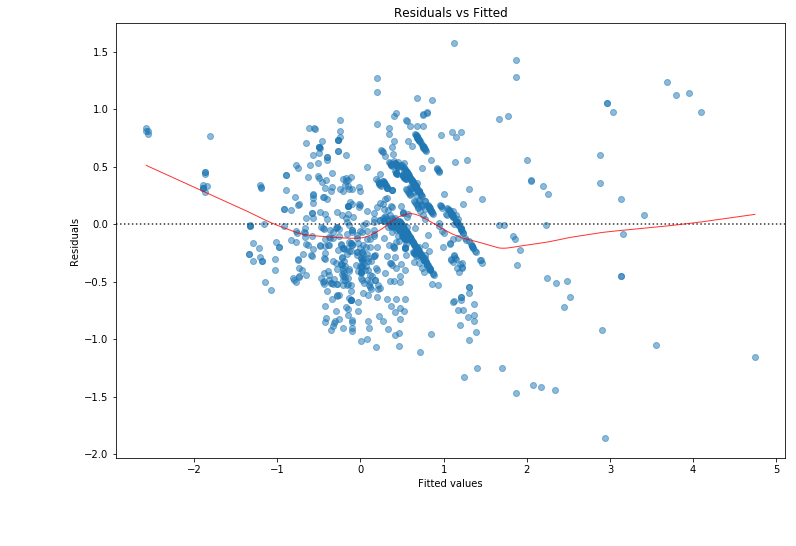

In [33]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y[:1000], 'y', data=data, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

In [34]:
pca_df.head()

,y,p1,p2,p3,BIODIESEL,CNG,DIESEL,DIESEL_ELECTRIC,E85,ELECTRIC,...,HYUNDAI,KIA,MITSUBISHI,RENAULT,SUZUKI,TATA_JAGUAR_LANDROVER,TJL,TOYOTA_DAIHATSU,VW,share
0,-1.204409,-1.393067,0.311033,0.171618,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.339857
1,-0.880235,-1.375802,0.165637,0.061885,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.339857
2,-0.107206,-0.940315,-0.188069,0.341022,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0.339857
3,0.042412,-1.054488,-0.174921,0.502390,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.339857
4,0.416458,-0.757287,-0.451669,0.797148,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.339857


In [36]:
dic_ft = {}
for i in functions.ft_dict.values():
    temp = pca_df.loc[all_data[i] == 1]
    if temp.shape[0] > 0:
        temp_lm = smf.ols(formula='y~%s'%'+'.join(temp.drop('y',axis=1).columns), data=temp).fit()
        dic_ft[i] = temp_lm

In [37]:
dic_mp = {}
for i in functions.mp_dict.values():
    temp = pca_df.loc[all_data[i] == 1]
    if temp.shape[0] > 0:
        temp_lm = smf.ols(formula='y~%s'%'+'.join(temp.drop('y',axis=1).columns), data=temp).fit()
        dic_mp[i] = temp_lm

In [38]:
for k in dic_ft:
    params = dic_ft[k].params[-(len(functions.mp_dict)-4):]
    if len(params) > 0:
        print(k, ':\n', params.where(params > 0).dropna(), '\n\n')

PETROL :
 FCA                      0.127875
FIAT                     0.395361
FORD                     0.046849
GM                       0.256897
HONDA                    0.163437
HYUNDAI                  0.178818
KIA                      0.163539
MITSUBISHI               0.195228
RENAULT                  0.391335
SUZUKI                   0.252440
TATA_JAGUAR_LANDROVER    0.247791
TJL                      0.781246
dtype: float64 


CNG :
 Series([], dtype: float64) 


BIODIESEL :
 DAIMLER    0.852093
FCA        1.481064
FORD       0.713142
SUZUKI     1.451213
VW         0.707363
share      0.437986
dtype: float64 


LPG :
 DAIMLER            0.937649
FCA                0.147239
FIAT               0.098645
FORD               0.137459
HONDA              0.154308
HYUNDAI            0.229157
KIA                0.119444
RENAULT            0.290368
SUZUKI             0.208482
TOYOTA_DAIHATSU    0.094106
VW                 0.355861
share              0.245230
dtype: float64 


BIOMETHANE :
 F

In [39]:
for k in dic_mp:
    params = dic_mp[k].params[4:16]
    print(k, ':\n', params.where(params > 0).dropna(), '\n\n')

SUZUKI :
 BIODIESEL          2.747306e-01
CNG                2.640567e-16
DIESEL             4.665571e-02
DIESEL_ELECTRIC    4.166209e-16
LPG                4.477255e-01
PETROL             5.104388e-01
dtype: float64 


MITSUBISHI :
 BIODIESEL          7.545619e-16
CNG                6.689400e-16
DIESEL             1.812479e-01
DIESEL_ELECTRIC    3.902515e-16
E85                1.002452e+00
LPG                5.791998e-01
PETROL             7.442767e-01
dtype: float64 


GM :
 BIODIESEL          1.737932e-14
CNG                2.640437e+00
DIESEL             2.621228e+00
DIESEL_ELECTRIC    4.816087e-15
E85                3.544637e+00
ELECTRIC           3.530660e-04
PETROL_ELECTRIC    1.549054e-01
HYDROGEN           1.262908e-14
LPG                3.028208e+00
BIOMETHANE         2.699983e+00
PETROL             3.335167e+00
dtype: float64 


KIA :
 BIODIESEL    1.798786e-15
DIESEL       6.244316e-01
LPG          1.232862e+00
PETROL       1.176374e+00
dtype: float64 


BMW :
 CNG       5.

In [41]:
len(dic_mp)

16

In [42]:
len(dic_ft)

10

In [52]:
ls = []
for i in functions.ft_dict.values():
    ls.append(i)
for i in np.unique(ls):
    temp = pca_df.loc[all_data[i] == 1]
    if temp.shape[0] > 1:
        print(i, ': ', temp.shape)

BIODIESEL :  (38, 34)
BIOMETHANE :  (723, 34)
DIESEL :  (102192, 34)
DIESEL_ELECTRIC :  (156, 34)
E85 :  (405, 34)
ELECTRIC :  (69, 34)
LPG :  (1470, 34)
PETROL :  (73362, 34)
PETROL_ELECTRIC :  (706, 34)


In [50]:
ls = []
for i in functions.mp_dict.values():
    ls.append(i)
for i in np.unique(ls):
    temp = pca_df.loc[all_data[i] == 1]
    print(i, ': ', temp.shape)

BMW :  (17445, 34)
DAIMLER :  (25621, 34)
FCA :  (2255, 34)
FIAT :  (2634, 34)
FORD :  (8503, 34)
GM :  (12709, 34)
HONDA :  (1663, 34)
HYUNDAI :  (3840, 34)
KIA :  (4334, 34)
MITSUBISHI :  (956, 34)
RENAULT :  (16945, 34)
SUZUKI :  (1003, 34)
TATA_JAGUAR_LANDROVER :  (4462, 34)
TJL :  (207, 34)
TOYOTA_DAIHATSU :  (6645, 34)
VW :  (56230, 34)
